In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, arrowhead_marker
import ipywidgets as widgets
from highlight_text import  ax_text, fig_text
import matplotlib as mpl

#Read in the data
df = pd.read_csv('Footballdata/Others/ManCity2/ManCity.csv', encoding='latin-1', low_memory=False)

#Adjust for pitch size
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

#remove
df = df.loc[~(df['type_displayName'] == 'Challenge')]
df = df.loc[~((df['type_displayName'] == 'Aerial') & (df['outcomeType_displayName'] == 'Unsuccessful'))]

#Finding previous event to filter out setpieces
df['prevevent'] = df['type_displayName'].shift(1)

#Remove passes that come after fouls and cards, potential set pieces
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Foul'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Card'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'CornerAwarded'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'OffsideGiven'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'SubstitutionOn'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'FormationChange'))]
df = df.loc[~((df['type_displayName'] == 'Pass') & (df['prevevent'] == 'Start'))]

#Filter for passes that starts before the final third and arrives in the final third
F3rd_pass = df.loc[((df['type_displayName']=='Pass') & (df['x'] < 80) & (df['endX'] >= 80))]

#Combo box, choose team
options = df["teamId"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
teamlist = widgets.Combobox(
    placeholder='Enter a team',
    options=options,
    description='Team:',
    ensure_option=True,
    disabled=False
)
teamlist

Combobox(value='', description='Team:', ensure_option=True, options=('29', 'Manchester City', '183', '23', '16…

In [3]:
#Filter for successful passes
S_F3rd_pass = F3rd_pass[F3rd_pass['outcomeType_displayName']=='Successful']

#Filter for successful passes
U_F3rd_pass = F3rd_pass[F3rd_pass['outcomeType_displayName']=='Unsuccessful']

#List of Pass Attempts
pass_list = F3rd_pass.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Attempted Passes'}).sort_values('name', ascending = True).reset_index()
del pass_list['index']

#List of Successful Passes
successful_pass_list = S_F3rd_pass.groupby(['name','teamId']).size().reset_index().rename(columns={0:'Successful Passes'}).sort_values('name', ascending = True).reset_index()
del successful_pass_list['index']

#Merge everything, only two at a time
result = pd.merge(pass_list, successful_pass_list, how='outer')
result.fillna(0, inplace=True)
result["Successful Passes"] = result["Successful Passes"].astype(int)

#Display List
result.rename(columns = {'teamId':'Team', 'name':'Player'},inplace = True)
result = result.sort_values('Successful Passes', ascending= False).reset_index(drop = True)
result.index += 1
result

,Player,Team,Attempted Passes,Successful Passes
1,Rodri,Manchester City,324,265
2,Kyle Walker,Manchester City,238,182
3,Nathan AkÃ©,Manchester City,188,159
4,Ilkay Gündogan,Manchester City,173,142
5,Manuel Akanji,Manchester City,169,137
...,...,...,...,...
328,Antony,32,1,0
329,Juan Larios,18,1,0
330,Julio Enciso,211,1,0
331,Junior Firpo,19,2,0


# Team

In [7]:
#Retrieve Team
team = teamlist.value

#Retrieve Opposition team (only use when there's two available teams for selection)
oppo = df.loc[(df['teamId']!= team)]
oppo = oppo['teamId'].unique()
oppo = oppo[0]

#Filter for team
TF3rd_pass = F3rd_pass[F3rd_pass['teamId']==team]
TS_F3rd_pass = S_F3rd_pass[S_F3rd_pass['teamId']==team]
TU_F3rd_pass = U_F3rd_pass[U_F3rd_pass['teamId']==team]

successful = len(TS_F3rd_pass)
unsuccessful = len(TU_F3rd_pass)

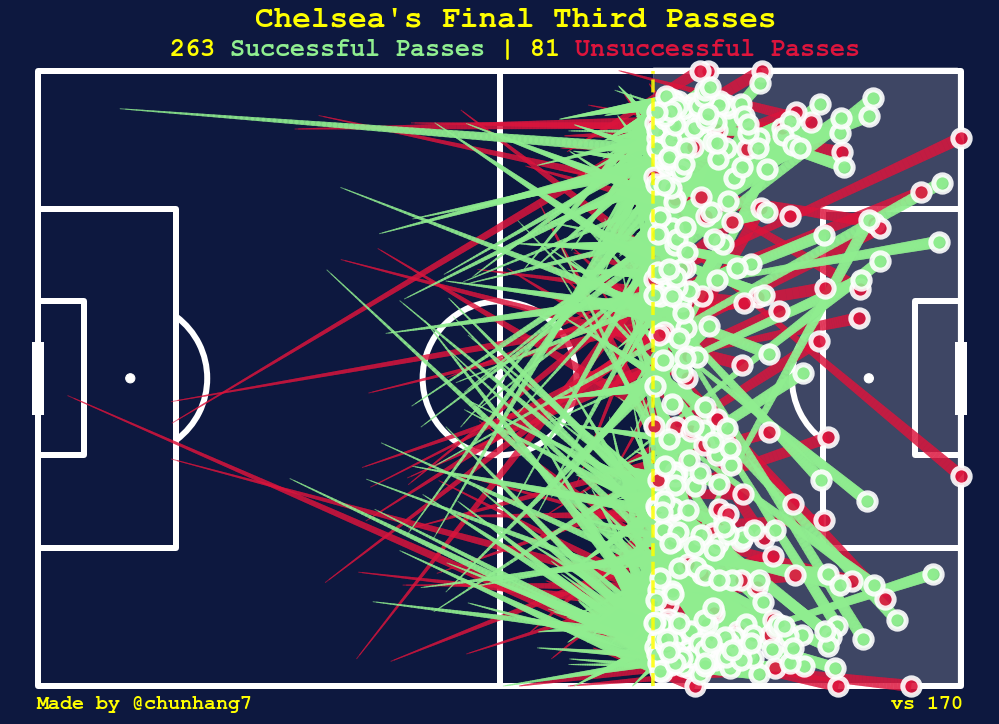

In [8]:
#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#0d183f', line_color='white',linewidth=6, spot_scale=0.005)
fig, ax = pitch.draw(figsize=(14, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#0d183f')

#Inverse y-axis
plt.gca().invert_yaxis()

#Draw line
ax.plot([80,80], [0, 80], c='yellow', lw=3.5, ls='--', zorder=9, alpha=0.85)

#Plot Unsuccessful Passes
pitch.lines(TU_F3rd_pass.x, TU_F3rd_pass.y, TU_F3rd_pass.endX, TU_F3rd_pass.endY,
            comet=True,ax=ax, linewidth=12, 
            alpha=0.6, color ='crimson')

pitch.scatter(TU_F3rd_pass['endX'], TU_F3rd_pass['endY'],
              edgecolors= "w", c="crimson", s = 300, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5, label='Unsuccessful Passes')

#Plot Successful Passes
pitch.lines(TS_F3rd_pass.x, TS_F3rd_pass.y, TS_F3rd_pass.endX, TS_F3rd_pass.endY,
            comet=True,ax=ax, linewidth=12, capstyle='round', 
            alpha=0.6, color ='lightgreen')

pitch.scatter(TS_F3rd_pass['endX'], TS_F3rd_pass['endY'],
              edgecolors= "w", c="lightgreen", s = 300, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5, label='Successful Passes')

#shade
plt.axvspan(80,119.5,ymin=0.05,ymax=0.96,color='lightgrey',zorder=-1,alpha=0.25)

#Title & Annotations
fig.suptitle(team +"'s Final Third Passes \n\n", fontsize=31, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",x=0.525,y=0.91)

highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'},
     {"color": "crimson","fontweight": 'bold'}]

Title = fig_text(s = str(successful) + " <Successful Passes> | " + str(unsuccessful) + " <Unsuccessful Passes>" ,
        x = 0.515, y = 0.87, highlight_textprops = highlight_textprops ,color='yellow',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=25);

#Annotations
fig.text(0.255, 0.03, 'Made by @chunhang7', fontsize=20, color='yellow', fontweight = 'bold', 
         fontfamily = 'Courier New',ha='right', va='center')

fig.text(0.96, 0.03,'vs ' + oppo, fontsize=20, color='yellow', fontweight = 'bold', 
         fontfamily = 'Courier New',ha='right', va='center')

plt.show()

# Player

In [9]:
#Combo box, choose team
options = df["playername"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
playerlist = widgets.Combobox(
    placeholder='Enter a player',
    options=options,
    description='Player:',
    ensure_option=True,
    disabled=False
)
playerlist

Combobox(value='', description='Player:', ensure_option=True, options=('Thiago Silva', 'Kai Havertz', 'BenoÃ®t…

In [10]:
#Retrieve player
player = playerlist.value
#player = 'Robin Knoche'
#Filter for player
F3rd_pass = F3rd_pass[F3rd_pass['playername']==player]
S_F3rd_pass = S_F3rd_pass[S_F3rd_pass['playername']==player]
U_F3rd_pass = U_F3rd_pass[U_F3rd_pass['playername']==player]

successful = len(S_F3rd_pass)
unsuccessful = len(U_F3rd_pass)

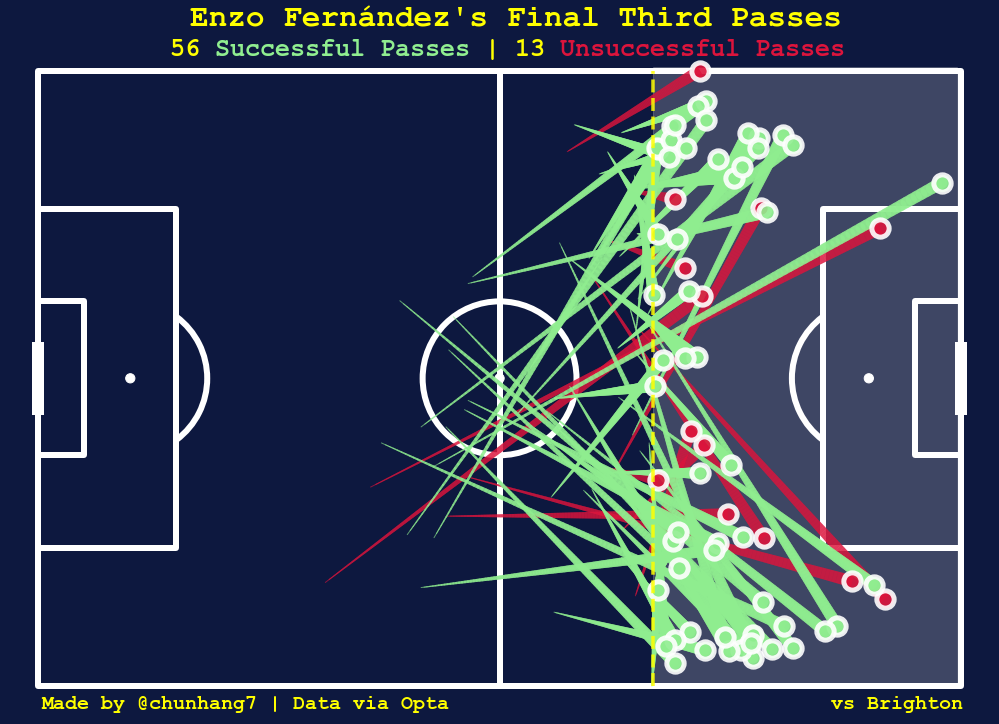

In [11]:
#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#0d183f', line_color='white',linewidth=6, spot_scale=0.005)
fig, ax = pitch.draw(figsize=(14, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#0d183f')

#Inverse y-axis
plt.gca().invert_yaxis()

#Draw line
ax.plot([80,80], [0, 80], c='yellow', lw=3.5, ls='--', zorder=9, alpha=0.85)

#Plot Unsuccessful Passes
pitch.lines(U_F3rd_pass.x, U_F3rd_pass.y, U_F3rd_pass.endX, U_F3rd_pass.endY,
            comet=True,ax=ax, linewidth=12, 
            alpha=0.6, color ='crimson')

pitch.scatter(U_F3rd_pass['endX'], U_F3rd_pass['endY'],
              edgecolors= "w", c="crimson", s = 300, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5, label='Unsuccessful Passes')

#Plot Successful Passes
pitch.lines(S_F3rd_pass.x, S_F3rd_pass.y, S_F3rd_pass.endX, S_F3rd_pass.endY,
            comet=True,ax=ax, linewidth=12, capstyle='round', 
            alpha=0.6, color ='lightgreen')

pitch.scatter(S_F3rd_pass['endX'], S_F3rd_pass['endY'],
              edgecolors= "w", c="lightgreen", s = 300, zorder=4, ax=ax, 
              marker = 'o', alpha = 0.9,linewidths=5, label='Successful Passes')

#shade
plt.axvspan(80,119.5,ymin=0.05,ymax=0.96,color='lightgrey',zorder=-1,alpha=0.25)

#Title & Annotations
fig.suptitle(player +"'s Final Third Passes \n\n", fontsize=31, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",x=0.525,y=0.91)

highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'},
     {"color": "crimson","fontweight": 'bold'}]

Title = fig_text(s = str(successful) + " <Successful Passes> | " + str(unsuccessful) + " <Unsuccessful Passes>" ,
        x = 0.508, y = 0.87, highlight_textprops = highlight_textprops ,color='yellow',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=25);

#Annotations
fig.text(0.45, 0.03, 'Made by @chunhang7 | Data via Opta', fontsize=20, color='yellow', fontweight = 'bold', 
         fontfamily = 'Courier New',ha='right', va='center')

fig.text(0.96, 0.03,'vs Brighton', fontsize=20, color='yellow', fontweight = 'bold', 
         fontfamily = 'Courier New',ha='right', va='center')

plt.show()

# Vertical Pitch

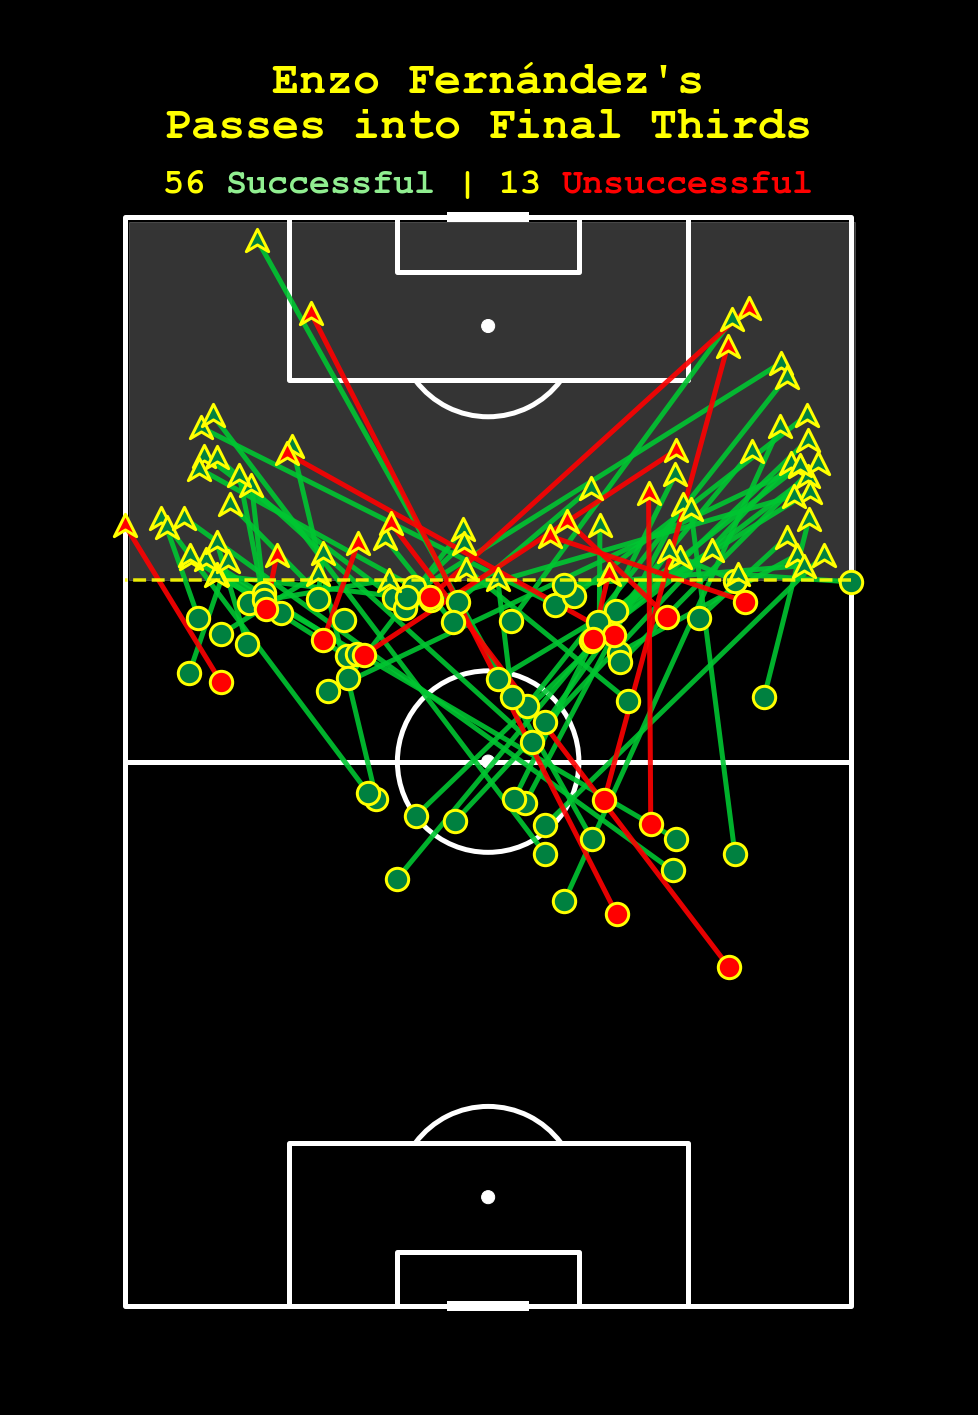

In [12]:
#Set up pitch
pitch = VerticalPitch(pitch_type='statsbomb', 
                  pitch_color='#000000', line_color='white',half = False,
                  line_zorder=1, linewidth=5, spot_scale=0.006)

fig,ax = pitch.draw(figsize=(30, 20), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#000000')

#Inverse the y-axis
plt.gca().invert_xaxis()

#Arrow

#Successful Passes
pitch.scatter(S_F3rd_pass.x,S_F3rd_pass.y, edgecolors= 'yellow', c='#008140',
              s = 500, zorder=4, ax=ax, marker = 'o', linewidth=3)

pitch.lines(S_F3rd_pass.x,S_F3rd_pass.y,S_F3rd_pass.endX,S_F3rd_pass.endY,
            ax=ax, color= '#00c631', lw=5, alpha = 0.9)

pitch.scatter(S_F3rd_pass.endX,S_F3rd_pass.endY, edgecolors= 'yellow', c='#008140',marker=arrowhead_marker,
              s = 500, zorder=4, ax=ax, linewidth=3)

#Unsuccessful Passes
pitch.scatter(U_F3rd_pass.x,U_F3rd_pass.y, edgecolors= 'yellow', c='red',
              s = 500, zorder=6, ax=ax, marker = 'o', linewidth=3)

pitch.lines(U_F3rd_pass.x,U_F3rd_pass.y,U_F3rd_pass.endX,U_F3rd_pass.endY,
            ax=ax, color= 'red', lw=5, alpha = 0.9)

pitch.scatter(U_F3rd_pass.endX,U_F3rd_pass.endY, edgecolors= 'yellow', c='red',marker=arrowhead_marker,
              s = 500, zorder=6, ax=ax, linewidth=3)


#Title
plt.text(40,119,"\n"+player +"'s\nPasses into Final Thirds\n\n",color='yellow', ha='center',
          size=45, fontfamily = "Courier New", fontweight = "bold")

#Annotation
highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'},
     {"color": "red","fontweight": 'bold'}]

fig_text(s = str(successful) + " <Successful> | " + str(unsuccessful) + " <Unsuccessful>" ,
        x = 0.5, y = 0.87, highlight_textprops = highlight_textprops ,color='yellow',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=35, zorder= 3);

#Draw line
ax.plot([0,80], [80, 80], c='yellow', lw=3.5, ls='--', zorder=9, alpha=0.9)

#shade
plt.axhspan(80,119.5,xmin=0.05,xmax=0.96,color='lightgrey',zorder=-1,alpha=0.25)

#Space
ax.text(45, 142, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')
ax.text(-5, -10, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')
ax.text(93, -10, 'Space', va='center', ha='left', fontsize=25, color='black',fontweight='bold',fontfamily='Courier New')

plt.show()